# Import Library

In [64]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [65]:
#Import Library
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import copy
import sys
import cv2
import os

# Import images :V

In [66]:
# Specify image size
img_size = 224

# Making function for create data from path
def create_data(test_data=False):
    
    # Checking for test or train data conditions
    
    # Test data
    if test_data:
        cracked = 'archive/testing_data/cracked'
        normal = 'archive/testing_data/normal'
        
    # Train data    
    else:
        cracked = 'archive/training_data/cracked'
        normal = 'archive/training_data/normal'
    
    
    # Labels for train and test
    Labels = {cracked:0, normal:1}
    
    # Initializing list for storing train and test data
    data = []
    
    # Initializing list for storing train and test label
    labels = np.array([])
    
    # Looping through each label
    for label in Labels:
        
        # Looping through cracked train data
        for ls in os.listdir(label):
            
            # Join each ls element with file path
            path = os.path.join(label, ls)

            # Read images from path using cv2
            img = cv2.imread(path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (img_size, img_size))

            # Adding data into data and labels list
            data.append(np.array(img))
            labels = np.append(labels, Labels[label])
    
    return np.array(data), labels
        

In [67]:
# Create train and test data with label
train_data, train_label = create_data(test_data=False)
test_data, test_label = create_data(test_data=True)

# Look at data size
print(f"Train data with shape {train_data.shape}")
print(f"Test data with shape {test_data.shape}")

Train data with shape (703, 224, 224, 3)
Test data with shape (325, 224, 224, 3)


# Look at images!!

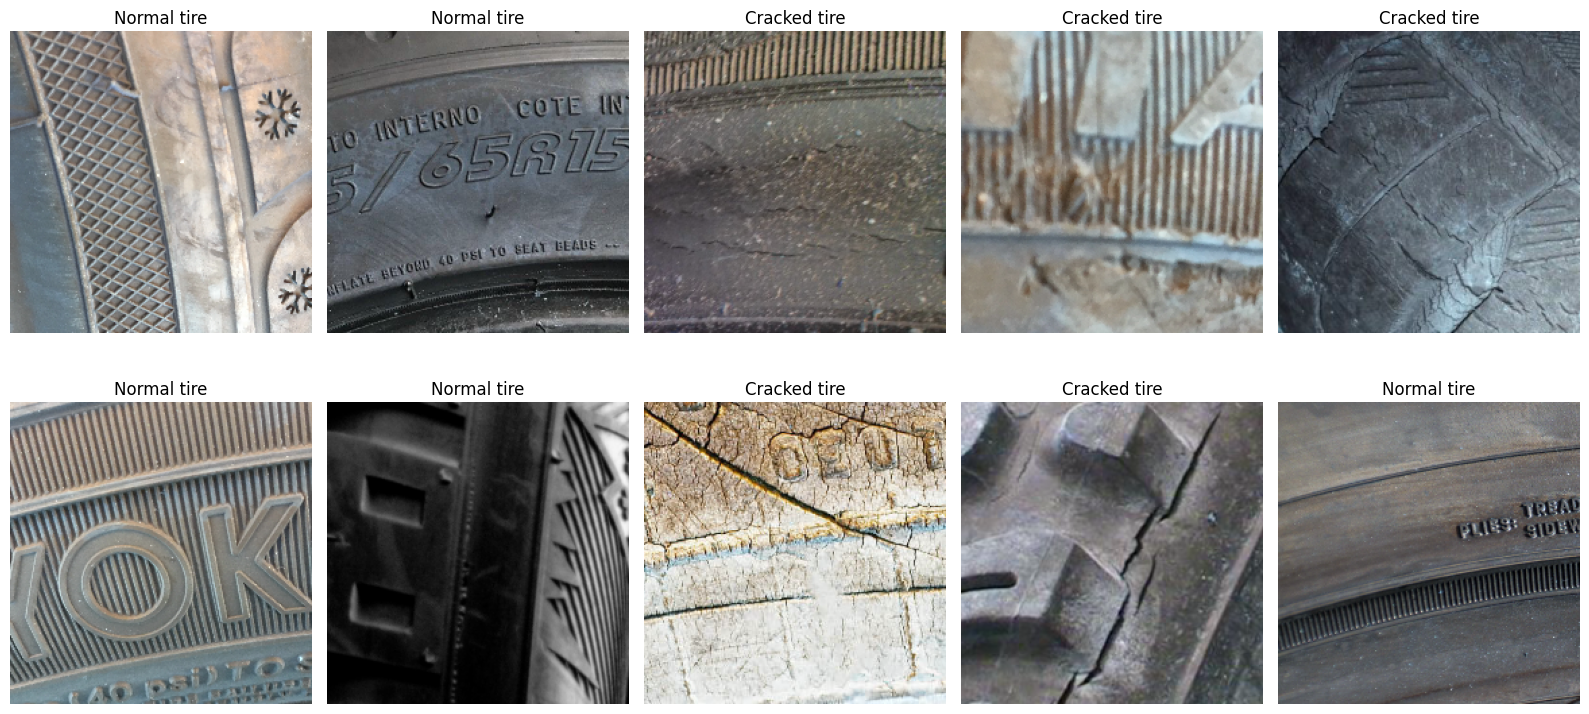

In [68]:
# Randomly choose image index
random_idx = np.random.randint(low=0, high=train_data.shape[0], size=10)

# Initializing fig and ax variables
fig, axs = plt.subplots(2, 5, figsize=(16,8))

# Looping through each axs
for i, ax in enumerate(axs.flatten()):

    # Showing image
    ax.imshow(train_data[random_idx[i],:], cmap='gray')
    ax.axis('off')
    
    # Set title for each image
    if train_label[random_idx[i]] ==0:
        ax.set_title(f"Cracked tire")
    else:
        ax.set_title(f"Normal tire")
fig.tight_layout()
plt.show()

# Data augmentation and Normalize data

In [69]:
# Normalize data
train_data = train_data/np.max(train_data)
test_data = test_data/np.max(test_data)
print(np.max(train_data))
print(np.max(test_data))

1.0
1.0


In [70]:
#Adding noise to data
noise_traindata = copy.deepcopy(train_data)
noise_traindata = (noise_traindata + np.random.rand(*noise_traindata.shape)/1.1)
noise_traindata = noise_traindata/np.max(noise_traindata)

In [71]:
train_data = np.concatenate((train_data, noise_traindata))
train_label = np.concatenate((train_label, train_label))
print(train_data.shape)
print(train_label.shape)

(1406, 224, 224, 3)
(1406,)


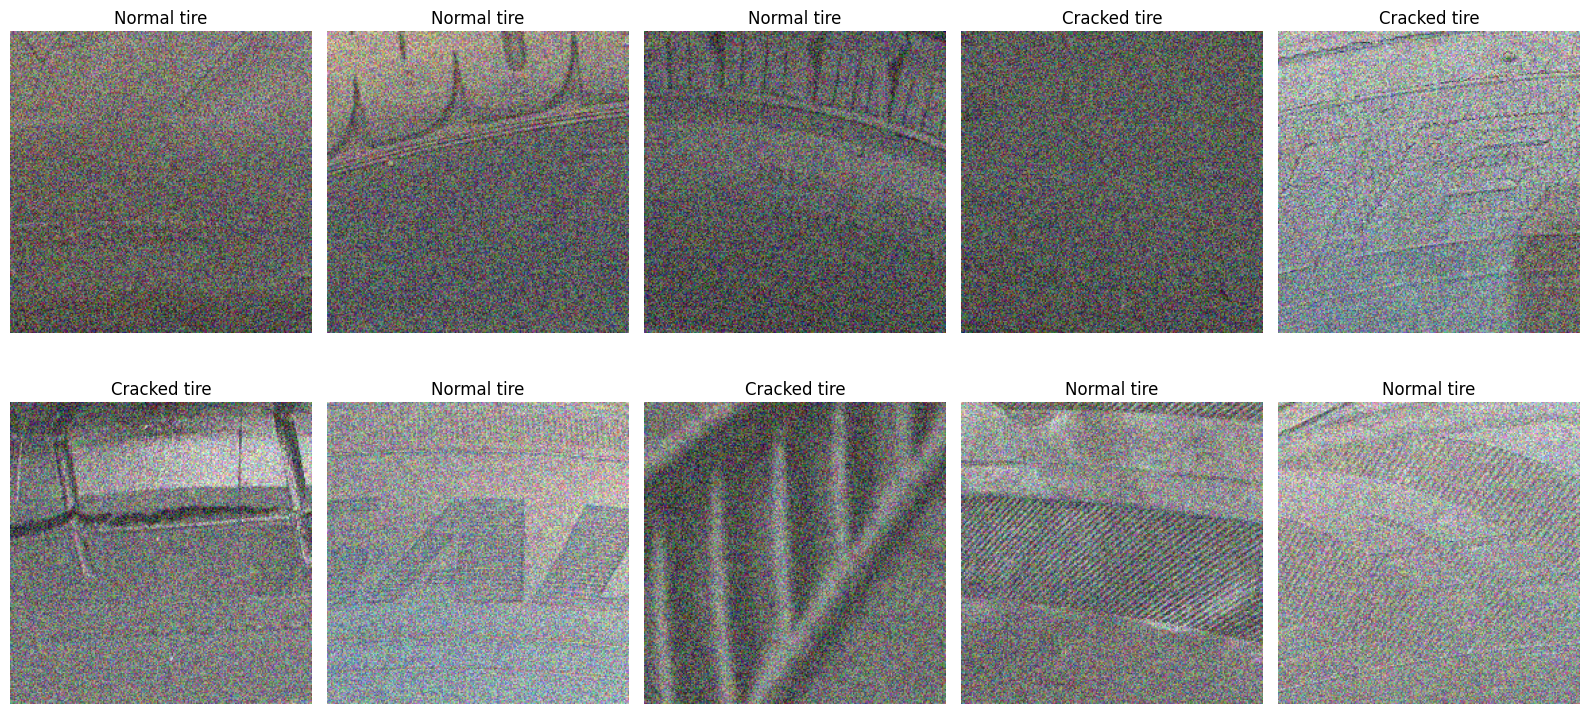

In [72]:
# Randomly choose image index
random_idx = np.random.randint(low=0, high=train_data.shape[0]/2, size=10)

# Initializing fig and ax variables
fig, axs = plt.subplots(2, 5, figsize=(16,8))

# Looping through each axs
for i, ax in enumerate(axs.flatten()):

    # Showing image
    ax.imshow(noise_traindata[random_idx[i],:], cmap='gray')
    ax.axis('off')
    
    # Set title for each image
    if train_label[random_idx[i]] ==0:
        ax.set_title(f"Cracked tire")
    else:
        ax.set_title(f"Normal tire")
fig.tight_layout()
plt.show()

# Make DataLoader object and turn train_data, test_data into Torch

In [73]:
# Turn train data, test_data, train_label, test_data from numpy to torch
train_dataT = torch.tensor(train_data.reshape(train_data.shape[0], 3, img_size, img_size)).float()
test_dataT = torch.tensor(test_data.reshape(test_data.shape[0], 3, img_size, img_size)).float()
# Label has to be a vector
train_labelT = torch.tensor(train_label.reshape(-1, 1)).float()
test_labelT = torch.tensor(test_label.reshape(-1, 1)).float()

print(f"Train data with shape {train_dataT.shape}")
print(f"Test data with shape {test_dataT.shape}")

print(f"Train label with shape {train_labelT.shape}")
print(f"Test label with shape {test_labelT.shape}")

Train data with shape torch.Size([1406, 3, 224, 224])
Test data with shape torch.Size([325, 3, 224, 224])
Train label with shape torch.Size([1406, 1])
Test label with shape torch.Size([325, 1])


In [74]:
# Split 80% to test and another to validation
test_data_split, val_data_split, test_label_split, val_label_split = train_test_split(
                                                                    test_dataT, test_labelT, test_size=.8,
                                                                    stratify=test_labelT)

# Create TensorDataset Object
train_tensor = torch.utils.data.TensorDataset(train_dataT, train_labelT)
test_tensor = torch.utils.data.TensorDataset(test_data_split, test_label_split)
val_tensor = torch.utils.data.TensorDataset(val_data_split, val_label_split)

# Create DataLoader Object
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_tensor, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_tensor, batch_size=test_tensor.tensors[0].shape[0])
val_loader = torch.utils.data.DataLoader(val_tensor, batch_size=batch_size, shuffle=True)

In [75]:
# Inspecting batches
print(f"Train batch size {len(train_loader)}")
print(f"Test batch size {len(test_loader)}")
print(f"Val batch size {len(val_loader)}")

Train batch size 87
Test batch size 1
Val batch size 17


# Create Model

In [76]:
# Create function for create my CNN models, optimizer, Loss function

def create_model(printsize=False):
    
    # CNN model class
    
    class TireNet(nn.Module):
        
        def __init__(self, printsize):
            
            super().__init__()
            
            # For printing size for each layer
            self.printsize = printsize
            
            # Model architecture (CNN Layers)
            
            self.con1 = nn.Conv2d(3, 32, 3, padding=1)
            self.bn1 = nn.BatchNorm2d(32)
            self.con2 = nn.Conv2d(32, 64, 5, stride=2)
            self.bn2 = nn.BatchNorm2d(64)
            self.con3 = nn.Conv2d(64, 128, 5, stride=2)
            self.bn3 = nn.BatchNorm2d(128)
#             self.con4 = nn.Conv2d(128, 128, 3)
#             self.bn4 = nn.BatchNorm2d(128)

            
            # Maxpool 
            self.pool = nn.MaxPool2d(2)

            # FFN layer
            self.fnn1 = nn.Linear(4608, 50)
            self.bnfnn = nn.BatchNorm1d(50)
            self.dropfnn = nn.Dropout(0.5)
            self.output = nn.Linear(50, 1)
        
        def forward(self, x):
            
            # CNN Layer 1
            if self.printsize: print(f"Input shape is {x.shape} before go to con1")
            x = F.relu(self.con1(x))
            x = self.bn1(x)
            x = self.pool(x)
            
            # CNN Layer 2 with maxpool
            if self.printsize: print(f"Input shape is {x.shape} after con1")
            x = F.relu(self.con2(x))
            x = self.bn2(x)
            x = self.pool(x)
            
            # CNN Layer 3
            if self.printsize: print(f"Input shape is {x.shape} after con2 and maxpool")
            x = F.relu(self.con3(x))
            x = self.bn3(x)
            x = self.pool(x)
            
#             # CNN Layer4 with maxpool
#             if self.printsize: print(f"Input shape is {x.shape} after con3")
#             x = F.relu(self.con4(x))
#             x = self.bn4(x)
#             x = self.pool(x)
            
            
                
            # Reshape x into vector
            x = x.view(x.shape[0], -1)
            if self.printsize: print(f"x size after reshape is {x.shape}")
                
            # FNN Layer 1 - 2
            x = F.relu(self.fnn1(x))
            x = self.bnfnn(x)

            return self.output(x)
    
    # Create variables for model, loss function, optimizer
    model = TireNet(printsize)
    lossfunc = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    return model, lossfunc, optimizer

In [77]:
# Test model with fake data and printsize for each CNN Layer
test_model= create_model(True)[0]

#Print Architecture in TireNet model
print(test_model)
print('='*100)
# Create some fake data
sample = torch.randn((10, 3, img_size, img_size))

# Use Noise model predict fake data
ypred = test_model(sample)

# Look at its shape and some result
print('='*100)
print(ypred.shape)
print('='*100)
print(ypred)

TireNet(
  (con1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fnn1): Linear(in_features=4608, out_features=50, bias=True)
  (bnfnn): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropfnn): Dropout(p=0.5, inplace=False)
  (output): Linear(in_features=50, out_features=1, bias=True)
)
Input shape is torch.Size([10, 3, 224, 224]) before go to con1
Input shape is torch.Size([10, 32, 112, 112]) after con1
Input shape is torch.Size([10, 64, 27, 27]) after con2 and ma

# Make function to train TireNet !!

In [78]:
# Checking for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [79]:
# Create train_model function
def train_model(model, lossfunc, optimizer, n_epochs, train_data, val_data):
    
    # For storing best perfrom model!
    bestmodel = {'acc': 0, 'net': None}
    
    # Initializing variables for storing result
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    
    # Use GPU for our model
    model = model.to(device)
    
    # Training loop
    for epochi in range(n_epochs):
        
        # Training mode
        model.train()
        
        # Variable for storing result each batch
        batch_train = []
        batch_loss = []
        
        # Training in train_data
        for X, y in train_data:
            
            # Push data into GPU
            X = X.to(device)
            y = y.to(device)
            
            # Predict model
            pred = model(X)
            # How many error in this prediction ? (compute for error)
            loss = lossfunc(pred, y)
            
            # Set gradient to zero
            optimizer.zero_grad()
            # Compute Loss
            loss.backward()
            # Do back prop
            optimizer.step()
            
            # Storing loss this batch into batch_loss
            batch_loss.append(loss.item())
            
            # move pred, y to CPU
            pred = pred.cpu()
            y = y.cpu()
            
            # Computing accuracy and storing result
            matches = ((pred>0)==y).float()
            batch_train.append(100*torch.mean(matches).item())
        
        # Compute average of batch_train and batch_loss
        train_acc.append(np.mean(batch_train))
        train_losses.append(np.mean(batch_loss))
            
        # Using eval mode
        model.eval()
        
        batch_val = []
        batch_val_loss = []
        # Testing in validation_data to avoid overfitting
        for X, y in val_data:
        
            # Push data into GPU
            X = X.to(device)
            y = y.to(device)

            # Using torch.no_grad() to switch off gradient computation
            with torch.no_grad():
                # Predict model
                pred = model(X)

            loss = lossfunc(pred, y)
            # Store test loss
            batch_val_loss.append(loss.item())

            # move pred to CPU
            pred = pred.cpu()
            y = y.cpu()

            matches = ((pred>0)==y).float()
            batch_val.append(100*torch.mean(matches).item())
        
        val_acc.append(np.mean(batch_val))
        val_losses.append(np.mean(batch_val_loss))
        # Craete msg for printing result
        msg = f"Epoch {epochi+1} out of {n_epochs} with Train acc {train_acc[-1]:.2f}% Val acc {val_acc[-1]:.2f}% and Val Loss {val_losses[-1]:.8f}"
        sys.stdout.write('\r'+msg)
        
        # Storing bestmodel
        if val_acc[-1] > bestmodel['acc']:
            
            bestmodel['acc'] = val_acc[-1].item()
            bestmodel['net'] = copy.deepcopy(model.state_dict())
    
    return train_acc, val_acc, train_losses, val_losses, model, bestmodel

# Train da model !!

In [80]:
# Create model instance
model, lossfunc, optimizer = create_model()
# Train with 150 epochs
numepochs = 100
train_acc, val_acc, train_losses, val_losses, model, bestmodel = train_model(model, lossfunc, optimizer, numepochs, train_loader, val_loader)

Epoch 16 out of 100 with Train acc 96.34% Val acc 56.25% and Val Loss 1.55819572

# Using best model! :D

In [ ]:
# Recreate new model
model = create_model()[0]

# Load best model
model.load_state_dict(bestmodel['net'])

torch.save(model.state_dict(), 'modelo_predicao_pth')

# Plotting training result

In [ ]:
# Testing set
test_set, test_set_label = next(iter(test_loader))

# Testing model on test set
test_result = model(test_set).cpu()
test_acc = 100*(torch.mean(((test_result>0)==test_set_label).float()).item())

print("Test accuracy is {:.2f}%".format(test_acc))

Test accuracy is 66.05%


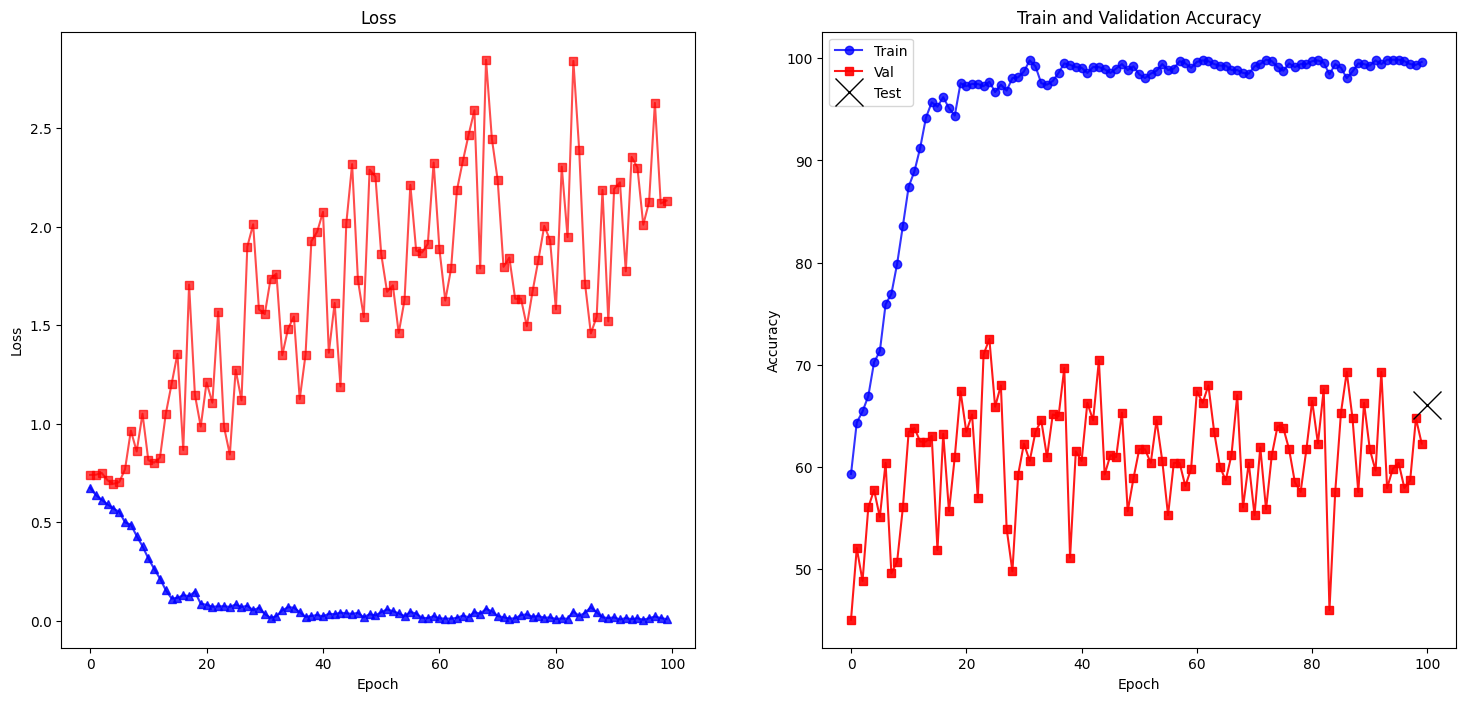

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Plot loss
axs[0].plot(train_losses, 'b^-', alpha=.8)
axs[0].plot(val_losses, 'rs-', alpha=.7)
axs[0].set_title('Loss')
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")

axs[1].plot(train_acc, 'bo-', alpha=.8, label='Train')
axs[1].plot(val_acc, 'rs-', alpha=.9, label='Val')
axs[1].plot(numepochs, test_acc, 'kx', alpha=1, markersize=20, label='Test')
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Train and Validation Accuracy")
axs[1].legend()
plt.show()

### Confusion matrix!

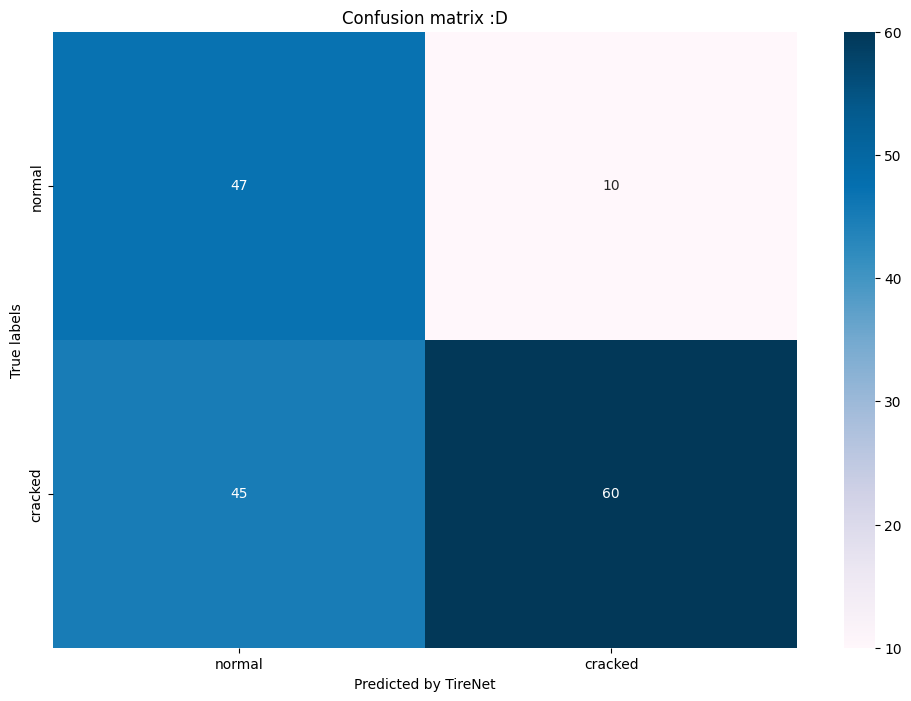

True positive: 60
True negative: 47
False positive: 10
False negative: 45


In [ ]:
# Calculating Confusion matrix
test_confu = skm.confusion_matrix(test_loader.dataset.tensors[1], (test_result>0).float(), labels=[1, 0])

fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(test_confu, cmap='PuBu', annot=True, ax=ax)
ax.set_xticks([0.5,1.5])
ax.set_xticklabels(['normal', 'cracked'])
ax.set_yticks([0.5,1.5])
ax.set_yticklabels(['normal', 'cracked'])
ax.set_xlabel('Predicted by TireNet')
ax.set_ylabel('True labels')
ax.set_title('Confusion matrix :D')
plt.show()

tn, fp, fn, tp = test_confu.ravel()
print('True positive: {}'.format(tp))
print('True negative: {}'.format(tn))
print('False positive: {}'.format(fp))
print('False negative: {}'.format(fn))
